# portfolio

In [1]:
import vectorbt as vbt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from numba import njit, f8, i8, b1, optional

In [3]:
from datetime import datetime
index = pd.Index([
    datetime(2020, 1, 1),
    datetime(2020, 1, 2),
    datetime(2020, 1, 3),
    datetime(2020, 1, 4),
    datetime(2020, 1, 5),
    datetime(2020, 1, 6),
    datetime(2020, 1, 7),
])
price = pd.DataFrame({
    'a': [1, 2, 3, 4, 5, 6, 7],
    'b': [9, 8, 7, 6, 5, 4, 3],
    'c': [1, 2, 3, 4, 3, 2, 1],
    'd': [4, 3, 2, 1, 2, 3, 4]
}, index=index).astype(float)

print(price)

              a    b    c    d
2020-01-01  1.0  9.0  1.0  4.0
2020-01-02  2.0  8.0  2.0  3.0
2020-01-03  3.0  7.0  3.0  2.0
2020-01-04  4.0  6.0  4.0  1.0
2020-01-05  5.0  5.0  3.0  2.0
2020-01-06  6.0  4.0  2.0  3.0
2020-01-07  7.0  3.0  1.0  4.0


In [4]:
big_price = pd.DataFrame(np.random.uniform(size=(1000, 1000)).astype(float))
big_price.index = [datetime(2018, 1, 1) + timedelta(days=i) for i in range(1000)]

print(big_price.shape)

(1000, 1000)


In [5]:
entries = pd.DataFrame.vbt.signals.generate_random(
    price.shape, 2, min_space=1, seed=42, index=price.index, columns=price.columns)
big_entries = pd.DataFrame.vbt.signals.generate_random(
    big_price.shape, 100, min_space=1, seed=42, index=big_price.index)

print(entries)

                a      b      c      d
2020-01-01  False  False   True  False
2020-01-02  False  False  False  False
2020-01-03   True   True  False   True
2020-01-04  False  False  False  False
2020-01-05   True   True  False  False
2020-01-06  False  False  False  False
2020-01-07  False  False   True   True


In [6]:
exits = entries.vbt.signals.generate_random_after(1, seed=42)
big_exits = big_entries.vbt.signals.generate_random_after(1, seed=42)

print(exits)

                a      b      c      d
2020-01-01  False  False  False  False
2020-01-02  False  False   True  False
2020-01-03  False  False  False  False
2020-01-04   True   True  False  False
2020-01-05  False  False  False   True
2020-01-06  False   True  False  False
2020-01-07   True  False  False  False


In [7]:
vbt.defaults.portfolio['init_capital'] = 100 # set init_capital in cash globally

In [8]:
# Disable caching for performance testing
# NOTE: Expect waterfall of executions, since some attributes depend on other attributes 
# that have to be calculated again and again
vbt.defaults.caching = False

## from_signals

In [9]:
portfolio = vbt.Portfolio.from_signals(price['a'], entries['a'], exits['a'], size=1)
print(portfolio.order_records)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_signals(big_price.iloc[:, 0], big_entries.iloc[:, 0], big_exits.iloc[:, 0])

   Column  Index  Size  Price  Fees  Side
0     0.0    2.0   1.0    3.0   0.0   0.0
1     0.0    3.0   1.0    4.0   0.0   1.0
2     0.0    4.0   1.0    5.0   0.0   0.0
3     0.0    6.0   1.0    7.0   0.0   1.0
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    1.0
2020-01-04    0.0
2020-01-05    1.0
2020-01-06    1.0
2020-01-07    0.0
Name: a, dtype: float64
2020-01-01    100.0
2020-01-02    100.0
2020-01-03     97.0
2020-01-04    101.0
2020-01-05     96.0
2020-01-06     96.0
2020-01-07    103.0
Name: a, dtype: float64
7.85 ms ± 410 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
portfolio = vbt.Portfolio.from_signals(price, entries, exits, size=1)
print(portfolio.order_records)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_signals(big_price, big_entries, big_exits, size=1)

    Column  Index  Size  Price  Fees  Side
0      0.0    2.0   1.0    3.0   0.0   0.0
1      0.0    3.0   1.0    4.0   0.0   1.0
2      0.0    4.0   1.0    5.0   0.0   0.0
3      0.0    6.0   1.0    7.0   0.0   1.0
4      1.0    2.0   1.0    7.0   0.0   0.0
5      1.0    3.0   1.0    6.0   0.0   1.0
6      1.0    4.0   1.0    5.0   0.0   0.0
7      1.0    5.0   1.0    4.0   0.0   1.0
8      2.0    0.0   1.0    1.0   0.0   0.0
9      2.0    1.0   1.0    2.0   0.0   1.0
10     2.0    6.0   1.0    1.0   0.0   0.0
11     3.0    2.0   1.0    2.0   0.0   0.0
12     3.0    4.0   1.0    2.0   0.0   1.0
13     3.0    6.0   1.0    4.0   0.0   0.0
              a    b    c    d
2020-01-01  0.0  0.0  1.0  0.0
2020-01-02  0.0  0.0  0.0  0.0
2020-01-03  1.0  1.0  0.0  1.0
2020-01-04  0.0  0.0  0.0  1.0
2020-01-05  1.0  1.0  0.0  0.0
2020-01-06  1.0  0.0  0.0  0.0
2020-01-07  0.0  0.0  1.0  1.0
                a      b      c      d
2020-01-01  100.0  100.0   99.0  100.0
2020-01-02  100.0  100.0  101

In [11]:
portfolio = vbt.Portfolio.from_signals(price, entries, exits, size=np.inf) # all in/out
print(portfolio.order_records)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_signals(big_price, big_entries, big_exits, size=np.inf)

    Column  Index        Size  Price  Fees  Side
0      0.0    2.0   33.333333    3.0   0.0   0.0
1      0.0    3.0   33.333333    4.0   0.0   1.0
2      0.0    4.0   26.666667    5.0   0.0   0.0
3      0.0    6.0   26.666667    7.0   0.0   1.0
4      1.0    2.0   14.285714    7.0   0.0   0.0
5      1.0    3.0   14.285714    6.0   0.0   1.0
6      1.0    4.0   17.142857    5.0   0.0   0.0
7      1.0    5.0   17.142857    4.0   0.0   1.0
8      2.0    0.0  100.000000    1.0   0.0   0.0
9      2.0    1.0  100.000000    2.0   0.0   1.0
10     2.0    6.0  200.000000    1.0   0.0   0.0
11     3.0    2.0   50.000000    2.0   0.0   0.0
12     3.0    4.0   50.000000    2.0   0.0   1.0
13     3.0    6.0   25.000000    4.0   0.0   0.0
                    a          b      c     d
2020-01-01   0.000000   0.000000  100.0   0.0
2020-01-02   0.000000   0.000000    0.0   0.0
2020-01-03  33.333333  14.285714    0.0  50.0
2020-01-04   0.000000   0.000000    0.0  50.0
2020-01-05  26.666667  17.142857   

In [12]:
portfolio = vbt.Portfolio.from_signals(price, entries, exits, size=1, fees=0.01) # w/ fees
print(portfolio.order_records)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_signals(big_price, big_entries, big_exits, size=1, fees=0.01)

    Column  Index  Size  Price  Fees  Side
0      0.0    2.0   1.0    3.0  0.03   0.0
1      0.0    3.0   1.0    4.0  0.04   1.0
2      0.0    4.0   1.0    5.0  0.05   0.0
3      0.0    6.0   1.0    7.0  0.07   1.0
4      1.0    2.0   1.0    7.0  0.07   0.0
5      1.0    3.0   1.0    6.0  0.06   1.0
6      1.0    4.0   1.0    5.0  0.05   0.0
7      1.0    5.0   1.0    4.0  0.04   1.0
8      2.0    0.0   1.0    1.0  0.01   0.0
9      2.0    1.0   1.0    2.0  0.02   1.0
10     2.0    6.0   1.0    1.0  0.01   0.0
11     3.0    2.0   1.0    2.0  0.02   0.0
12     3.0    4.0   1.0    2.0  0.02   1.0
13     3.0    6.0   1.0    4.0  0.04   0.0
              a    b    c    d
2020-01-01  0.0  0.0  1.0  0.0
2020-01-02  0.0  0.0  0.0  0.0
2020-01-03  1.0  1.0  0.0  1.0
2020-01-04  0.0  0.0  0.0  1.0
2020-01-05  1.0  1.0  0.0  0.0
2020-01-06  1.0  0.0  0.0  0.0
2020-01-07  0.0  0.0  1.0  1.0
                 a       b       c       d
2020-01-01  100.00  100.00   98.99  100.00
2020-01-02  100.00  1

In [13]:
portfolio = vbt.Portfolio.from_signals(price, entries, exits, size=1, fixed_fees=1) # w/ fixed fees
print(portfolio.order_records)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_signals(big_price, big_entries, big_exits, size=1, fixed_fees=1)

    Column  Index  Size  Price  Fees  Side
0      0.0    2.0   1.0    3.0   1.0   0.0
1      0.0    3.0   1.0    4.0   1.0   1.0
2      0.0    4.0   1.0    5.0   1.0   0.0
3      0.0    6.0   1.0    7.0   1.0   1.0
4      1.0    2.0   1.0    7.0   1.0   0.0
5      1.0    3.0   1.0    6.0   1.0   1.0
6      1.0    4.0   1.0    5.0   1.0   0.0
7      1.0    5.0   1.0    4.0   1.0   1.0
8      2.0    0.0   1.0    1.0   1.0   0.0
9      2.0    1.0   1.0    2.0   1.0   1.0
10     2.0    6.0   1.0    1.0   1.0   0.0
11     3.0    2.0   1.0    2.0   1.0   0.0
12     3.0    4.0   1.0    2.0   1.0   1.0
13     3.0    6.0   1.0    4.0   1.0   0.0
              a    b    c    d
2020-01-01  0.0  0.0  1.0  0.0
2020-01-02  0.0  0.0  0.0  0.0
2020-01-03  1.0  1.0  0.0  1.0
2020-01-04  0.0  0.0  0.0  1.0
2020-01-05  1.0  1.0  0.0  0.0
2020-01-06  1.0  0.0  0.0  0.0
2020-01-07  0.0  0.0  1.0  1.0
                a      b     c      d
2020-01-01  100.0  100.0  98.0  100.0
2020-01-02  100.0  100.0  99.0 

In [14]:
portfolio = vbt.Portfolio.from_signals(price, entries, exits, size=1, slippage=0.01) # w/ slippage
print(portfolio.order_records)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_signals(big_price, big_entries, big_exits, size=1, slippage=0.01)

    Column  Index  Size  Price  Fees  Side
0      0.0    2.0   1.0   3.03   0.0   0.0
1      0.0    3.0   1.0   3.96   0.0   1.0
2      0.0    4.0   1.0   5.05   0.0   0.0
3      0.0    6.0   1.0   6.93   0.0   1.0
4      1.0    2.0   1.0   7.07   0.0   0.0
5      1.0    3.0   1.0   5.94   0.0   1.0
6      1.0    4.0   1.0   5.05   0.0   0.0
7      1.0    5.0   1.0   3.96   0.0   1.0
8      2.0    0.0   1.0   1.01   0.0   0.0
9      2.0    1.0   1.0   1.98   0.0   1.0
10     2.0    6.0   1.0   1.01   0.0   0.0
11     3.0    2.0   1.0   2.02   0.0   0.0
12     3.0    4.0   1.0   1.98   0.0   1.0
13     3.0    6.0   1.0   4.04   0.0   0.0
              a    b    c    d
2020-01-01  0.0  0.0  1.0  0.0
2020-01-02  0.0  0.0  0.0  0.0
2020-01-03  1.0  1.0  0.0  1.0
2020-01-04  0.0  0.0  0.0  1.0
2020-01-05  1.0  1.0  0.0  0.0
2020-01-06  1.0  0.0  0.0  0.0
2020-01-07  0.0  0.0  1.0  1.0
                 a       b       c       d
2020-01-01  100.00  100.00   98.99  100.00
2020-01-02  100.00  1

## from_orders

In [15]:
order_size = pd.DataFrame.vbt.timeseries.empty_like(price, 1) # buy 1 share every day
big_order_size = pd.DataFrame.vbt.timeseries.empty_like(big_price, 1)

In [16]:
portfolio = vbt.Portfolio.from_orders(price['a'], order_size['a'])
print(portfolio.order_records)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_orders(big_price.iloc[:, 0], big_order_size.iloc[:, 0])

   Column  Index  Size  Price  Fees  Side
0     0.0    0.0   1.0    1.0   0.0   0.0
1     0.0    1.0   1.0    2.0   0.0   0.0
2     0.0    2.0   1.0    3.0   0.0   0.0
3     0.0    3.0   1.0    4.0   0.0   0.0
4     0.0    4.0   1.0    5.0   0.0   0.0
5     0.0    5.0   1.0    6.0   0.0   0.0
6     0.0    6.0   1.0    7.0   0.0   0.0
2020-01-01    1.0
2020-01-02    2.0
2020-01-03    3.0
2020-01-04    4.0
2020-01-05    5.0
2020-01-06    6.0
2020-01-07    7.0
Name: a, dtype: float64
2020-01-01    99.0
2020-01-02    97.0
2020-01-03    94.0
2020-01-04    90.0
2020-01-05    85.0
2020-01-06    79.0
2020-01-07    72.0
Name: a, dtype: float64
5.8 ms ± 285 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
portfolio = vbt.Portfolio.from_orders(price, order_size)
print(portfolio.order_records)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_orders(big_price, big_order_size)

    Column  Index  Size  Price  Fees  Side
0      0.0    0.0   1.0    1.0   0.0   0.0
1      0.0    1.0   1.0    2.0   0.0   0.0
2      0.0    2.0   1.0    3.0   0.0   0.0
3      0.0    3.0   1.0    4.0   0.0   0.0
4      0.0    4.0   1.0    5.0   0.0   0.0
5      0.0    5.0   1.0    6.0   0.0   0.0
6      0.0    6.0   1.0    7.0   0.0   0.0
7      1.0    0.0   1.0    9.0   0.0   0.0
8      1.0    1.0   1.0    8.0   0.0   0.0
9      1.0    2.0   1.0    7.0   0.0   0.0
10     1.0    3.0   1.0    6.0   0.0   0.0
11     1.0    4.0   1.0    5.0   0.0   0.0
12     1.0    5.0   1.0    4.0   0.0   0.0
13     1.0    6.0   1.0    3.0   0.0   0.0
14     2.0    0.0   1.0    1.0   0.0   0.0
15     2.0    1.0   1.0    2.0   0.0   0.0
16     2.0    2.0   1.0    3.0   0.0   0.0
17     2.0    3.0   1.0    4.0   0.0   0.0
18     2.0    4.0   1.0    3.0   0.0   0.0
19     2.0    5.0   1.0    2.0   0.0   0.0
20     2.0    6.0   1.0    1.0   0.0   0.0
21     3.0    0.0   1.0    4.0   0.0   0.0
22     3.0 

In [18]:
portfolio = vbt.Portfolio.from_orders(price, order_size, is_target=True) # target size
print(portfolio.order_records)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_orders(big_price, big_order_size, is_target=True)

   Column  Index  Size  Price  Fees  Side
0     0.0    0.0   1.0    1.0   0.0   0.0
1     1.0    0.0   1.0    9.0   0.0   0.0
2     2.0    0.0   1.0    1.0   0.0   0.0
3     3.0    0.0   1.0    4.0   0.0   0.0
              a    b    c    d
2020-01-01  1.0  1.0  1.0  1.0
2020-01-02  1.0  1.0  1.0  1.0
2020-01-03  1.0  1.0  1.0  1.0
2020-01-04  1.0  1.0  1.0  1.0
2020-01-05  1.0  1.0  1.0  1.0
2020-01-06  1.0  1.0  1.0  1.0
2020-01-07  1.0  1.0  1.0  1.0
               a     b     c     d
2020-01-01  99.0  91.0  99.0  96.0
2020-01-02  99.0  91.0  99.0  96.0
2020-01-03  99.0  91.0  99.0  96.0
2020-01-04  99.0  91.0  99.0  96.0
2020-01-05  99.0  91.0  99.0  96.0
2020-01-06  99.0  91.0  99.0  96.0
2020-01-07  99.0  91.0  99.0  96.0
54 ms ± 402 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## from_order_func

In [19]:
fees = 0.01
fixed_fees = 1
slippage = 0.01

@njit
def order_func_nb(col, i, run_cash, run_shares, price):
    return vbt.portfolio.nb.Order(-i if i % 2 == 0 else i, price[i, col], fees, fixed_fees, slippage)

portfolio = vbt.Portfolio.from_order_func(price['a'], order_func_nb, price.values)
print(portfolio.order_records)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_order_func(big_price.iloc[:, 0], order_func_nb, big_price.values)

   Column  Index  Size  Price    Fees  Side
0     0.0    1.0   1.0   2.02  1.0202   0.0
1     0.0    2.0   1.0   2.97  1.0297   1.0
2     0.0    3.0   3.0   4.04  1.1212   0.0
3     0.0    4.0   3.0   4.95  1.1485   1.0
4     0.0    5.0   5.0   6.06  1.3030   0.0
5     0.0    6.0   5.0   6.93  1.3465   1.0
2020-01-01    0.0
2020-01-02    1.0
2020-01-03    0.0
2020-01-04    3.0
2020-01-05    0.0
2020-01-06    5.0
2020-01-07    0.0
Name: a, dtype: float64
2020-01-01    100.0000
2020-01-02     96.9598
2020-01-03     98.9001
2020-01-04     85.6589
2020-01-05     99.3604
2020-01-06     67.7574
2020-01-07    101.0609
Name: a, dtype: float64
2.15 ms ± 271 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
portfolio = vbt.Portfolio.from_order_func(price, order_func_nb, price.values)
print(portfolio.order_records)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_order_func(big_price, order_func_nb, big_price.values)

    Column  Index  Size  Price    Fees  Side
0      0.0    1.0   1.0   2.02  1.0202   0.0
1      0.0    2.0   1.0   2.97  1.0297   1.0
2      0.0    3.0   3.0   4.04  1.1212   0.0
3      0.0    4.0   3.0   4.95  1.1485   1.0
4      0.0    5.0   5.0   6.06  1.3030   0.0
5      0.0    6.0   5.0   6.93  1.3465   1.0
6      1.0    1.0   1.0   8.08  1.0808   0.0
7      1.0    2.0   1.0   6.93  1.0693   1.0
8      1.0    3.0   3.0   6.06  1.1818   0.0
9      1.0    4.0   3.0   4.95  1.1485   1.0
10     1.0    5.0   5.0   4.04  1.2020   0.0
11     1.0    6.0   5.0   2.97  1.1485   1.0
12     2.0    1.0   1.0   2.02  1.0202   0.0
13     2.0    2.0   1.0   2.97  1.0297   1.0
14     2.0    3.0   3.0   4.04  1.1212   0.0
15     2.0    4.0   3.0   2.97  1.0891   1.0
16     2.0    5.0   5.0   2.02  1.1010   0.0
17     2.0    6.0   5.0   0.99  1.0495   1.0
18     3.0    1.0   1.0   3.03  1.0303   0.0
19     3.0    2.0   1.0   1.98  1.0198   1.0
20     3.0    3.0   3.0   1.01  1.0303   0.0
21     3.0

## Properties

In [21]:
# One column
portfolio_a = vbt.Portfolio.from_signals(
    price['a'], entries['a'], exits['a'], fees=0.01,
    risk_free=0.01, required_return=0.1, cutoff=0.07, 
    factor_returns=np.random.uniform(size=price.shape[0]))
print(portfolio_a.price.shape)
portfolio = vbt.Portfolio.from_signals(
    price, entries, exits, fees=0.01,
    risk_free=0.01, required_return=0.1, cutoff=0.07, 
    factor_returns=np.random.uniform(size=price.shape))
print(portfolio.price.shape)

# Multiple columns
big_portfolio_a = vbt.Portfolio.from_signals(
    big_price[0], big_entries[0], big_exits[0], fees=0.01,
    risk_free=0.01, required_return=0.1, cutoff=0.07, 
    factor_returns=np.random.uniform(size=big_price.shape[0]))
print(big_portfolio_a.price.shape)
big_portfolio = vbt.Portfolio.from_signals(
    big_price, big_entries, big_exits, fees=0.01,
    risk_free=0.01, required_return=0.1, cutoff=0.07, 
    factor_returns=np.random.uniform(size=big_price.shape))
print(big_portfolio.price.shape)

(7,)
(7, 4)
(1000,)
(1000, 1000)


In [22]:
print(portfolio.init_capital)
print(portfolio.price)
print(portfolio.cash)
print(portfolio.shares)

100
              a    b    c    d
2020-01-01  1.0  9.0  1.0  4.0
2020-01-02  2.0  8.0  2.0  3.0
2020-01-03  3.0  7.0  3.0  2.0
2020-01-04  4.0  6.0  4.0  1.0
2020-01-05  5.0  5.0  3.0  2.0
2020-01-06  6.0  4.0  2.0  3.0
2020-01-07  7.0  3.0  1.0  4.0
                       a           b           c           d
2020-01-01  1.000000e+02  100.000000    0.000000  100.000000
2020-01-02  1.000000e+02  100.000000  196.039604  100.000000
2020-01-03 -1.421085e-14    0.000000  196.039604    0.000000
2020-01-04  1.306931e+02   84.016973  196.039604    0.000000
2020-01-05  0.000000e+00    0.000000  196.039604   98.019802
2020-01-06  0.000000e+00   65.882617  196.039604   98.019802
2020-01-07  1.793471e+02   65.882617    0.000000    0.000000
                    a          b           c          d
2020-01-01   0.000000   0.000000   99.009901   0.000000
2020-01-02   0.000000   0.000000    0.000000   0.000000
2020-01-03  33.003300  14.144272    0.000000  49.504950
2020-01-04   0.000000   0.000000    

In [23]:
print(portfolio.data_freq)
print(portfolio.year_freq)
print(portfolio.ann_factor)
print(portfolio.risk_free)
print(portfolio.required_return)
print(portfolio.cutoff)
print(portfolio.factor_returns)

1 days 00:00:00
365 days 05:49:12
365.2425
0.01
0.1
0.07
                   a         b         c         d
2020-01-01  0.870147  0.261076  0.036430  0.265255
2020-01-02  0.884610  0.695212  0.686213  0.001662
2020-01-03  0.120155  0.683872  0.442295  0.189147
2020-01-04  0.136374  0.868007  0.700792  0.192035
2020-01-05  0.426088  0.197941  0.814747  0.852869
2020-01-06  0.943961  0.508545  0.159171  0.534067
2020-01-07  0.651458  0.596186  0.299866  0.895747


## Orders

In [24]:
print(portfolio_a.order_records)
print(portfolio.order_records)

   Column  Index       Size  Price      Fees  Side
0     0.0    2.0  33.003300    3.0  0.990099   0.0
1     0.0    3.0  33.003300    4.0  1.320132   1.0
2     0.0    4.0  25.879816    5.0  1.293991   0.0
3     0.0    6.0  25.879816    7.0  1.811587   1.0
    Column  Index        Size  Price      Fees  Side
0      0.0    2.0   33.003300    3.0  0.990099   0.0
1      0.0    3.0   33.003300    4.0  1.320132   1.0
2      0.0    4.0   25.879816    5.0  1.293991   0.0
3      0.0    6.0   25.879816    7.0  1.811587   1.0
4      1.0    2.0   14.144272    7.0  0.990099   0.0
5      1.0    3.0   14.144272    6.0  0.848656   1.0
6      1.0    4.0   16.637024    5.0  0.831851   0.0
7      1.0    5.0   16.637024    4.0  0.665481   1.0
8      2.0    0.0   99.009901    1.0  0.990099   0.0
9      2.0    1.0   99.009901    2.0  1.980198   1.0
10     2.0    6.0  194.098618    1.0  1.940986   0.0
11     3.0    2.0   49.504950    2.0  0.990099   0.0
12     3.0    4.0   49.504950    2.0  0.990099   1.0
13 

In [25]:
print(portfolio_a.orders)

In [26]:
print(portfolio_a.orders.buy)
print(portfolio_a.orders.sell)

In [27]:
print(portfolio_a.orders.size)
print(portfolio.orders.size)

%timeit big_portfolio.orders.size

2020-01-01          NaN
2020-01-02          NaN
2020-01-03    33.003300
2020-01-04    33.003300
2020-01-05    25.879816
2020-01-06          NaN
2020-01-07    25.879816
Name: a, dtype: float64
                    a          b           c          d
2020-01-01        NaN        NaN   99.009901        NaN
2020-01-02        NaN        NaN   99.009901        NaN
2020-01-03  33.003300  14.144272         NaN  49.504950
2020-01-04  33.003300  14.144272         NaN        NaN
2020-01-05  25.879816  16.637024         NaN  49.504950
2020-01-06        NaN  16.637024         NaN        NaN
2020-01-07  25.879816        NaN  194.098618  24.262327
4.36 ms ± 53.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
print(portfolio_a.orders.buy.size)
print(portfolio.orders.buy.size)

%timeit big_portfolio.orders.buy.size

2020-01-01          NaN
2020-01-02          NaN
2020-01-03    33.003300
2020-01-04          NaN
2020-01-05    25.879816
2020-01-06          NaN
2020-01-07          NaN
Name: a, dtype: float64
                    a          b           c          d
2020-01-01        NaN        NaN   99.009901        NaN
2020-01-02        NaN        NaN         NaN        NaN
2020-01-03  33.003300  14.144272         NaN  49.504950
2020-01-04        NaN        NaN         NaN        NaN
2020-01-05  25.879816  16.637024         NaN        NaN
2020-01-06        NaN        NaN         NaN        NaN
2020-01-07        NaN        NaN  194.098618  24.262327
7.64 ms ± 167 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
print(portfolio_a.orders.sell.size)
print(portfolio.orders.sell.size)

%timeit big_portfolio.orders.sell.size

2020-01-01          NaN
2020-01-02          NaN
2020-01-03          NaN
2020-01-04    33.003300
2020-01-05          NaN
2020-01-06          NaN
2020-01-07    25.879816
Name: a, dtype: float64
                    a          b          c         d
2020-01-01        NaN        NaN        NaN       NaN
2020-01-02        NaN        NaN  99.009901       NaN
2020-01-03        NaN        NaN        NaN       NaN
2020-01-04  33.003300  14.144272        NaN       NaN
2020-01-05        NaN        NaN        NaN  49.50495
2020-01-06        NaN  16.637024        NaN       NaN
2020-01-07  25.879816        NaN        NaN       NaN
9.19 ms ± 2.18 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [30]:
print(portfolio_a.orders.price)
print(portfolio.orders.price)

%timeit big_portfolio.orders.price

2020-01-01    NaN
2020-01-02    NaN
2020-01-03    3.0
2020-01-04    4.0
2020-01-05    5.0
2020-01-06    NaN
2020-01-07    7.0
Name: a, dtype: float64
              a    b    c    d
2020-01-01  NaN  NaN  1.0  NaN
2020-01-02  NaN  NaN  2.0  NaN
2020-01-03  3.0  7.0  NaN  2.0
2020-01-04  4.0  6.0  NaN  NaN
2020-01-05  5.0  5.0  NaN  2.0
2020-01-06  NaN  4.0  NaN  NaN
2020-01-07  7.0  NaN  1.0  4.0
5.42 ms ± 878 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [31]:
print(portfolio_a.orders.fees)
print(portfolio.orders.fees)

%timeit big_portfolio.orders.fees

2020-01-01         NaN
2020-01-02         NaN
2020-01-03    0.990099
2020-01-04    1.320132
2020-01-05    1.293991
2020-01-06         NaN
2020-01-07    1.811587
Name: a, dtype: float64
                   a         b         c         d
2020-01-01       NaN       NaN  0.990099       NaN
2020-01-02       NaN       NaN  1.980198       NaN
2020-01-03  0.990099  0.990099       NaN  0.990099
2020-01-04  1.320132  0.848656       NaN       NaN
2020-01-05  1.293991  0.831851       NaN  0.990099
2020-01-06       NaN  0.665481       NaN       NaN
2020-01-07  1.811587       NaN  1.940986  0.970493
6.52 ms ± 1.61 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
print(portfolio_a.orders.total_fees)
print(portfolio.orders.total_fees)

%timeit big_portfolio.orders.total_fees

5.415808907623429
a    5.415809
b    3.336087
c    4.911283
d    2.950691
dtype: float64
13.7 ms ± 6.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Trades

In [33]:
print(portfolio_a.trade_records)
print(portfolio.trade_records)

   Column       Size  OpenAt  OpenPrice  OpenFees  CloseAt  ClosePrice  \
0     0.0  33.003300     2.0        3.0  0.990099      3.0         4.0   
1     0.0  25.879816     4.0        5.0  1.293991      6.0         7.0   

   CloseFees        PnL    Return  Position  
0   1.320132  30.693069  0.306931       0.0  
1   1.811587  48.654054  0.372277       1.0  
   Column       Size  OpenAt  OpenPrice  OpenFees  CloseAt  ClosePrice  \
0     0.0  33.003300     2.0        3.0  0.990099      3.0         4.0   
1     0.0  25.879816     4.0        5.0  1.293991      6.0         7.0   
2     1.0  14.144272     2.0        7.0  0.990099      3.0         6.0   
3     1.0  16.637024     4.0        5.0  0.831851      5.0         4.0   
4     2.0  99.009901     0.0        1.0  0.990099      1.0         2.0   
5     3.0  49.504950     2.0        2.0  0.990099      4.0         2.0   

   CloseFees        PnL    Return  Position  
0   1.320132  30.693069  0.306931       0.0  
1   1.811587  48.654054  0.3

In [34]:
print(portfolio_a.trades)

In [35]:
print(portfolio_a.trades.winning)
print(portfolio_a.trades.losing)

In [36]:
print(portfolio_a.trades.count)
print(portfolio.trades.count)

%timeit big_portfolio.trades.count

2.0
a    2.0
b    2.0
c    1.0
d    1.0
dtype: float64
6.09 ms ± 160 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [37]:
print(portfolio_a.trades.winning.count)
print(portfolio.trades.winning.count)

%timeit big_portfolio.trades.winning.count

2.0
a    2.0
b    NaN
c    1.0
d    NaN
dtype: float64
8.53 ms ± 61.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [38]:
print(portfolio_a.trades.losing.count)
print(portfolio.trades.losing.count)

%timeit big_portfolio.trades.losing.count

nan
a    NaN
b    2.0
c    NaN
d    1.0
dtype: float64
8.61 ms ± 32 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [39]:
print(portfolio_a.trades.duration)
print(portfolio.trades.duration)

%timeit big_portfolio.trades.duration

2020-01-01    NaN
2020-01-02    NaN
2020-01-03    NaN
2020-01-04    1.0
2020-01-05    NaN
2020-01-06    NaN
2020-01-07    2.0
Name: a, dtype: float64
              a    b    c    d
2020-01-01  NaN  NaN  NaN  NaN
2020-01-02  NaN  NaN  1.0  NaN
2020-01-03  NaN  NaN  NaN  NaN
2020-01-04  1.0  1.0  NaN  NaN
2020-01-05  NaN  NaN  NaN  2.0
2020-01-06  NaN  1.0  NaN  NaN
2020-01-07  2.0  NaN  NaN  NaN
9.58 ms ± 2.47 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [40]:
print(portfolio_a.trades.avg_duration)
print(portfolio.trades.avg_duration)

%timeit big_portfolio.trades.avg_duration

1 days 12:00:00
a   1 days 12:00:00
b   1 days 00:00:00
c   1 days 00:00:00
d   2 days 00:00:00
dtype: timedelta64[ns]
22 ms ± 2.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
print(portfolio_a.trades.pnl)
print(portfolio.trades.pnl)

%timeit big_portfolio.trades.pnl

2020-01-01          NaN
2020-01-02          NaN
2020-01-03          NaN
2020-01-04    30.693069
2020-01-05          NaN
2020-01-06          NaN
2020-01-07    48.654054
Name: a, dtype: float64
                    a          b          c         d
2020-01-01        NaN        NaN        NaN       NaN
2020-01-02        NaN        NaN  96.039604       NaN
2020-01-03        NaN        NaN        NaN       NaN
2020-01-04  30.693069 -15.983027        NaN       NaN
2020-01-05        NaN        NaN        NaN -1.980198
2020-01-06        NaN -18.134357        NaN       NaN
2020-01-07  48.654054        NaN        NaN       NaN
10 ms ± 1.71 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [42]:
print(portfolio_a.trades.total_pnl)
print(portfolio.trades.total_pnl)

%timeit big_portfolio.trades.total_pnl

79.34712283109498
a    79.347123
b   -34.117383
c    96.039604
d    -1.980198
dtype: float64
14.2 ms ± 35.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [43]:
print(portfolio_a.trades.avg_pnl)
print(portfolio.trades.avg_pnl)

%timeit big_portfolio.trades.avg_pnl

39.67356141554749
a    39.673561
b   -17.058692
c    96.039604
d    -1.980198
dtype: float64
14.6 ms ± 63.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


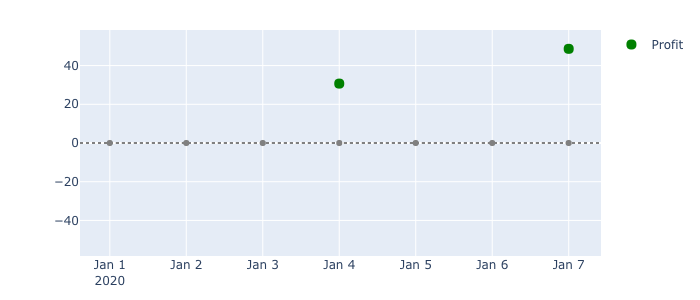

In [44]:
portfolio_a.trades.plot_pnl().show_png()

In [45]:
print(portfolio_a.trades.returns)
print(portfolio.trades.returns)

%timeit big_portfolio.trades.returns

2020-01-01         NaN
2020-01-02         NaN
2020-01-03         NaN
2020-01-04    0.306931
2020-01-05         NaN
2020-01-06         NaN
2020-01-07    0.372277
Name: a, dtype: float64
                   a         b         c         d
2020-01-01       NaN       NaN       NaN       NaN
2020-01-02       NaN       NaN  0.960396       NaN
2020-01-03       NaN       NaN       NaN       NaN
2020-01-04  0.306931 -0.159830       NaN       NaN
2020-01-05       NaN       NaN       NaN -0.019802
2020-01-06       NaN -0.215842       NaN       NaN
2020-01-07  0.372277       NaN       NaN       NaN
11.1 ms ± 2.77 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [46]:
print(portfolio_a.trades.avg_return)
print(portfolio.trades.avg_return)

%timeit big_portfolio.trades.avg_return

0.3396039603960396
a    0.339604
b   -0.187836
c    0.960396
d   -0.019802
dtype: float64
24.6 ms ± 6.48 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


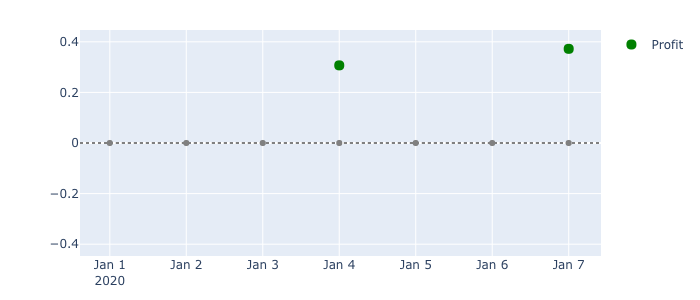

In [47]:
portfolio_a.trades.plot_returns().show_png()

In [48]:
print(portfolio_a.trades.win_rate)
print(portfolio.trades.win_rate)

%timeit big_portfolio.trades.win_rate

1.0
a    1.0
b    NaN
c    1.0
d    NaN
dtype: float64
10.1 ms ± 737 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [49]:
print(portfolio_a.trades.profit_factor)
print(portfolio.trades.profit_factor)

%timeit big_portfolio.trades.profit_factor

inf
a    inf
b    0.0
c    inf
d    0.0
dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/records.py:230: RuntimeWarning:

divide by zero encountered in true_divide



29.6 ms ± 2.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [50]:
print(portfolio_a.trades.expectancy)
print(portfolio.trades.expectancy)

%timeit big_portfolio.trades.expectancy

39.67356141554749
a    39.673561
b          NaN
c    96.039604
d          NaN
dtype: float64
34.2 ms ± 2.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Positions

In [51]:
print(portfolio_a.position_records)
print(portfolio.position_records)

   Column       Size  OpenAt  OpenPrice  OpenFees  CloseAt  ClosePrice  \
0     0.0  33.003300     2.0        3.0  0.990099      3.0         4.0   
1     0.0  25.879816     4.0        5.0  1.293991      6.0         7.0   

   CloseFees        PnL    Return  Status  
0   1.320132  30.693069  0.306931     1.0  
1   1.811587  48.654054  0.372277     1.0  
   Column        Size  OpenAt  OpenPrice  OpenFees  CloseAt  ClosePrice  \
0     0.0   33.003300     2.0        3.0  0.990099      3.0         4.0   
1     0.0   25.879816     4.0        5.0  1.293991      6.0         7.0   
2     1.0   14.144272     2.0        7.0  0.990099      3.0         6.0   
3     1.0   16.637024     4.0        5.0  0.831851      5.0         4.0   
4     2.0   99.009901     0.0        1.0  0.990099      1.0         2.0   
5     2.0  194.098618     6.0        1.0  1.940986      6.0         1.0   
6     3.0   49.504950     2.0        2.0  0.990099      4.0         2.0   
7     3.0   24.262327     6.0        4.0  0.9

In [52]:
print(portfolio_a.positions)

In [53]:
print(portfolio_a.positions.open)
print(portfolio_a.positions.closed)

In [54]:
print(portfolio_a.positions.winning)
print(portfolio_a.positions.losing)
print(portfolio_a.positions.open.winning)
print(portfolio_a.positions.open.losing)
print(portfolio_a.positions.closed.winning)
print(portfolio_a.positions.closed.losing)

In [55]:
print(portfolio_a.positions.status)
print(portfolio.positions.status)

%timeit big_portfolio.positions.status

2020-01-01    NaN
2020-01-02    NaN
2020-01-03    NaN
2020-01-04    1.0
2020-01-05    NaN
2020-01-06    NaN
2020-01-07    1.0
Name: a, dtype: float64
              a    b    c    d
2020-01-01  NaN  NaN  NaN  NaN
2020-01-02  NaN  NaN  1.0  NaN
2020-01-03  NaN  NaN  NaN  NaN
2020-01-04  1.0  1.0  NaN  NaN
2020-01-05  NaN  NaN  NaN  1.0
2020-01-06  NaN  1.0  NaN  NaN
2020-01-07  1.0  NaN  0.0  0.0
8.37 ms ± 770 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [56]:
print(portfolio_a.positions.closed_rate)
print(portfolio.positions.closed_rate)

%timeit big_portfolio.positions.closed_rate

1.0
a    1.0
b    1.0
c    0.5
d    0.5
dtype: float64
11.9 ms ± 1.63 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [57]:
print(portfolio_a.positions.count)
print(portfolio.positions.count)

%timeit big_portfolio.positions.count

2.0
a    2.0
b    2.0
c    2.0
d    2.0
dtype: float64
7.36 ms ± 1.94 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [58]:
print(portfolio_a.positions.winning.count)
print(portfolio.positions.winning.count)

%timeit big_portfolio.positions.winning.count

2.0
a    2.0
b    NaN
c    1.0
d    NaN
dtype: float64
10.2 ms ± 2.48 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [59]:
print(portfolio_a.positions.losing.count)
print(portfolio.positions.losing.count)

%timeit big_portfolio.positions.losing.count

nan
a    NaN
b    2.0
c    1.0
d    2.0
dtype: float64
8.85 ms ± 382 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [60]:
print(portfolio_a.positions.closed.winning.count)
print(portfolio.positions.closed.winning.count)

%timeit big_portfolio.positions.closed.winning.count

2.0
a    2.0
b    NaN
c    1.0
d    NaN
dtype: float64
13.1 ms ± 292 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [61]:
print(portfolio_a.positions.closed.losing.count)
print(portfolio.positions.closed.losing.count)

%timeit big_portfolio.positions.closed.losing.count

nan
a    NaN
b    2.0
c    NaN
d    1.0
dtype: float64
13.2 ms ± 419 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [62]:
print(portfolio_a.positions.duration)
print(portfolio.positions.duration)

%timeit big_portfolio.positions.duration

2020-01-01    NaN
2020-01-02    NaN
2020-01-03    NaN
2020-01-04    1.0
2020-01-05    NaN
2020-01-06    NaN
2020-01-07    2.0
Name: a, dtype: float64
              a    b    c    d
2020-01-01  NaN  NaN  NaN  NaN
2020-01-02  NaN  NaN  1.0  NaN
2020-01-03  NaN  NaN  NaN  NaN
2020-01-04  1.0  1.0  NaN  NaN
2020-01-05  NaN  NaN  NaN  2.0
2020-01-06  NaN  1.0  NaN  NaN
2020-01-07  2.0  NaN  0.0  0.0
8.62 ms ± 671 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [63]:
print(portfolio_a.positions.avg_duration)
print(portfolio.positions.avg_duration)

%timeit big_portfolio.positions.avg_duration

1 days 12:00:00
a   1 days 12:00:00
b   1 days 00:00:00
c   0 days 12:00:00
d   1 days 00:00:00
dtype: timedelta64[ns]
21.7 ms ± 2.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [64]:
print(portfolio_a.positions.pnl)
print(portfolio.positions.pnl)

%timeit big_portfolio.positions.pnl

2020-01-01          NaN
2020-01-02          NaN
2020-01-03          NaN
2020-01-04    30.693069
2020-01-05          NaN
2020-01-06          NaN
2020-01-07    48.654054
Name: a, dtype: float64
                    a          b          c         d
2020-01-01        NaN        NaN        NaN       NaN
2020-01-02        NaN        NaN  96.039604       NaN
2020-01-03        NaN        NaN        NaN       NaN
2020-01-04  30.693069 -15.983027        NaN       NaN
2020-01-05        NaN        NaN        NaN -1.980198
2020-01-06        NaN -18.134357        NaN       NaN
2020-01-07  48.654054        NaN  -1.940986 -0.970493
9.43 ms ± 2.2 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [65]:
print(portfolio_a.positions.total_pnl)
print(portfolio.positions.total_pnl)

%timeit big_portfolio.positions.total_pnl

79.34712283109498
a    79.347123
b   -34.117383
c    94.098618
d    -2.950691
dtype: float64
15.5 ms ± 1.71 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [66]:
print(portfolio_a.positions.avg_pnl)
print(portfolio.positions.avg_pnl)

%timeit big_portfolio.positions.avg_pnl

39.67356141554749
a    39.673561
b   -17.058692
c    47.049309
d    -1.475346
dtype: float64
22.6 ms ± 7.19 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


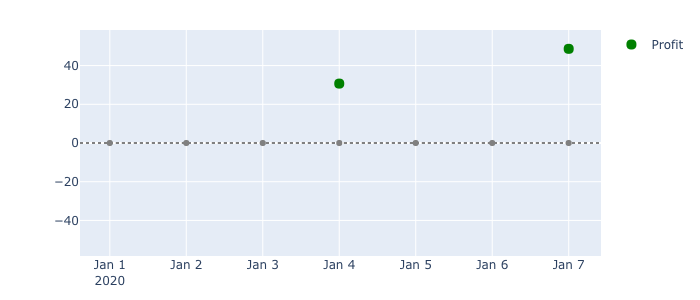

In [67]:
portfolio_a.positions.plot_pnl().show_png()

In [68]:
print(portfolio_a.positions.returns)
print(portfolio.positions.returns)

%timeit big_portfolio.positions.returns

2020-01-01         NaN
2020-01-02         NaN
2020-01-03         NaN
2020-01-04    0.306931
2020-01-05         NaN
2020-01-06         NaN
2020-01-07    0.372277
Name: a, dtype: float64
                   a         b         c         d
2020-01-01       NaN       NaN       NaN       NaN
2020-01-02       NaN       NaN  0.960396       NaN
2020-01-03       NaN       NaN       NaN       NaN
2020-01-04  0.306931 -0.159830       NaN       NaN
2020-01-05       NaN       NaN       NaN -0.019802
2020-01-06       NaN -0.215842       NaN       NaN
2020-01-07  0.372277       NaN -0.009901 -0.009901
8.11 ms ± 134 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [69]:
print(portfolio_a.positions.avg_return)
print(portfolio.positions.avg_return)

%timeit big_portfolio.positions.avg_return

0.3396039603960396
a    0.339604
b   -0.187836
c    0.475248
d   -0.014851
dtype: float64
15.1 ms ± 268 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


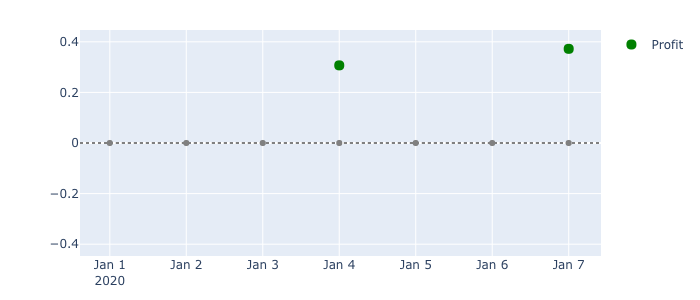

In [70]:
portfolio_a.positions.plot_returns().show_png()

In [71]:
print(portfolio_a.positions.win_rate)
print(portfolio.positions.win_rate)

%timeit big_portfolio.positions.win_rate

1.0
a    1.0
b    NaN
c    0.5
d    NaN
dtype: float64
9.73 ms ± 202 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [72]:
print(portfolio_a.positions.profit_factor)
print(portfolio.positions.profit_factor)

%timeit big_portfolio.positions.profit_factor

inf
a          inf
b     0.000000
c    49.479798
d     0.000000
dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/records.py:230: RuntimeWarning:

divide by zero encountered in true_divide



30.2 ms ± 2.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [73]:
print(portfolio_a.positions.expectancy)
print(portfolio.positions.expectancy)

%timeit big_portfolio.positions.expectancy

39.67356141554749
a    39.673561
b          NaN
c    47.049309
d          NaN
dtype: float64
34.9 ms ± 2.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Equity

In [74]:
print(portfolio_a.equity)
print(portfolio.equity)

%timeit big_portfolio.equity

2020-01-01    100.000000
2020-01-02    100.000000
2020-01-03     99.009901
2020-01-04    130.693069
2020-01-05    129.399079
2020-01-06    155.278894
2020-01-07    179.347123
Name: a, dtype: float64
                     a           b           c           d
2020-01-01  100.000000  100.000000   99.009901  100.000000
2020-01-02  100.000000  100.000000  196.039604  100.000000
2020-01-03   99.009901   99.009901  196.039604   99.009901
2020-01-04  130.693069   84.016973  196.039604   49.504950
2020-01-05  129.399079   83.185122  196.039604   98.019802
2020-01-06  155.278894   65.882617  196.039604   98.019802
2020-01-07  179.347123   65.882617  194.098618   97.049309
4.52 ms ± 89.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [75]:
print(portfolio_a.total_profit)
print(portfolio.total_profit)

%timeit big_portfolio.total_profit

79.34712283109496
a    79.347123
b   -34.117383
c    94.098618
d    -2.950691
dtype: float64
6.07 ms ± 57 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Returns

In [76]:
print(portfolio_a.returns)
print(portfolio.returns)

%timeit big_portfolio.equity.pct_change()
%timeit big_portfolio.returns # numba helps a lot

2020-01-01         NaN
2020-01-02    0.000000
2020-01-03   -0.009901
2020-01-04    0.320000
2020-01-05   -0.009901
2020-01-06    0.200000
2020-01-07    0.155000
Name: a, dtype: float64
                   a         b         c         d
2020-01-01       NaN       NaN       NaN       NaN
2020-01-02  0.000000  0.000000  0.980000  0.000000
2020-01-03 -0.009901 -0.009901  0.000000 -0.009901
2020-01-04  0.320000 -0.151429  0.000000 -0.500000
2020-01-05 -0.009901 -0.009901  0.000000  0.980000
2020-01-06  0.200000 -0.208000  0.000000  0.000000
2020-01-07  0.155000  0.000000 -0.009901 -0.009901
276 ms ± 8.17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
10.8 ms ± 150 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [77]:
print(portfolio_a.daily_returns)
print(portfolio.daily_returns)

%timeit big_portfolio.daily_returns

2020-01-01         NaN
2020-01-02    0.000000
2020-01-03   -0.009901
2020-01-04    0.320000
2020-01-05   -0.009901
2020-01-06    0.200000
2020-01-07    0.155000
Name: a, dtype: float64
                   a         b         c         d
2020-01-01       NaN       NaN       NaN       NaN
2020-01-02  0.000000  0.000000  0.980000  0.000000
2020-01-03 -0.009901 -0.009901  0.000000 -0.009901
2020-01-04  0.320000 -0.151429  0.000000 -0.500000
2020-01-05 -0.009901 -0.009901  0.000000  0.980000
2020-01-06  0.200000 -0.208000  0.000000  0.000000
2020-01-07  0.155000  0.000000 -0.009901 -0.009901
21.6 ms ± 985 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [78]:
print(portfolio_a.annual_returns)
print(portfolio.annual_returns)

%timeit big_portfolio.annual_returns

2020-12-31    0.793471
Freq: A-DEC, Name: a, dtype: float64
                   a         b         c         d
2020-12-31  0.793471 -0.341174  0.960396 -0.029507
34 ms ± 1.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [79]:
print(portfolio_a.total_return)
print(portfolio.total_return)

%timeit big_portfolio.total_return

0.7934712283109496
a    0.793471
b   -0.341174
c    0.940986
d   -0.029507
dtype: float64
6.18 ms ± 56.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Drawdown

In [80]:
print(portfolio_a.drawdown)
print(portfolio.drawdown)

%timeit big_portfolio.drawdown

2020-01-01    0.000000
2020-01-02    0.000000
2020-01-03    0.009901
2020-01-04    0.000000
2020-01-05    0.009901
2020-01-06    0.000000
2020-01-07    0.000000
Name: a, dtype: float64
                   a         b         c         d
2020-01-01  0.000000  0.000000  0.000000  0.000000
2020-01-02  0.000000  0.000000  0.000000  0.000000
2020-01-03  0.009901  0.009901  0.000000  0.009901
2020-01-04  0.000000  0.159830  0.000000  0.504950
2020-01-05  0.009901  0.168149  0.000000  0.019802
2020-01-06  0.000000  0.341174  0.000000  0.019802
2020-01-07  0.000000  0.341174  0.009901  0.029507
19.7 ms ± 1.33 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [81]:
print(portfolio_a.max_drawdown)
print(portfolio.max_drawdown)

%timeit big_portfolio.max_drawdown

0.00990099009901002
a    0.009901
b    0.341174
c    0.009901
d    0.504950
dtype: float64
23.9 ms ± 1.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Financial risk and performance metrics

In [82]:
import empyrical

print(empyrical.cum_returns(portfolio_a.returns.values))

print(portfolio_a.cum_returns)
print(portfolio.cum_returns)

%timeit big_portfolio.cum_returns

[ 0.          0.         -0.00990099  0.30693069  0.29399079  0.55278894
  0.79347123]
2020-01-01         NaN
2020-01-02    0.000000
2020-01-03   -0.009901
2020-01-04    0.306931
2020-01-05    0.293991
2020-01-06    0.552789
2020-01-07    0.793471
Name: a, dtype: float64
                   a         b         c         d
2020-01-01       NaN       NaN       NaN       NaN
2020-01-02  0.000000  0.000000  0.980000  0.000000
2020-01-03 -0.009901 -0.009901  0.980000 -0.009901
2020-01-04  0.306931 -0.159830  0.980000 -0.504950
2020-01-05  0.293991 -0.168149  0.980000 -0.019802
2020-01-06  0.552789 -0.341174  0.980000 -0.019802
2020-01-07  0.793471 -0.341174  0.960396 -0.029507
23.3 ms ± 1.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [83]:
print(empyrical.annual_return(portfolio_a.returns.values, annualization=portfolio.ann_factor))

print(portfolio_a.annualized_return)
print(portfolio.annualized_return)

%timeit big_portfolio.annualized_return

17263954475535.037
17263954475535.11
a    1.726395e+13
b   -1.000000e+00
c    1.793781e+15
d   -7.904448e-01
dtype: float64
17 ms ± 391 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [84]:
print(empyrical.annual_volatility(portfolio_a.returns.values, annualization=portfolio.ann_factor))

print(portfolio_a.annualized_volatility)
print(portfolio.annualized_volatility)

%timeit big_portfolio.annualized_volatility

2.635334446531104
2.6353344465311035
a    2.635334
b    1.760346
c    7.661944
d    9.265734
dtype: float64
18.6 ms ± 115 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [85]:
print(empyrical.calmar_ratio(portfolio_a.returns.values, annualization=portfolio.ann_factor))

print(portfolio_a.calmar_ratio)
print(portfolio.calmar_ratio)

%timeit big_portfolio.calmar_ratio

1743659402029022.8
1743659402029025.0
a    1.743659e+15
b   -2.931057e+00
c    1.811719e+17
d   -1.565391e+00
dtype: float64
53.4 ms ± 2.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [86]:
print(empyrical.omega_ratio(portfolio_a.returns.values, 
    annualization=portfolio.ann_factor, risk_free=portfolio.risk_free, required_return=portfolio.required_return))

print(portfolio_a.omega_ratio)
print(portfolio.omega_ratio)

%timeit big_portfolio.omega_ratio

12.735354206625322


/Users/olegpolakow/miniconda3/lib/python3.7/site-packages/empyrical/stats.py:641: RuntimeWarning:

invalid value encountered in greater

/Users/olegpolakow/miniconda3/lib/python3.7/site-packages/empyrical/stats.py:642: RuntimeWarning:

invalid value encountered in less



12.735354206625322
a    12.735354
b     0.000000
c    15.843878
d     1.697999
dtype: float64
23.4 ms ± 1.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [87]:
print(empyrical.sharpe_ratio(portfolio_a.returns.values, 
    annualization=portfolio.ann_factor, risk_free=portfolio.risk_free))

print(portfolio_a.sharpe_ratio)
print(portfolio.sharpe_ratio)

%timeit big_portfolio.sharpe_ratio

13.748515109956141
13.748515109956145
a    13.748515
b   -15.188840
c     7.230690
d     2.629209
dtype: float64
19.7 ms ± 1.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [88]:
print(empyrical.downside_risk(portfolio_a.returns.values, 
    annualization=portfolio.ann_factor, required_return=portfolio.required_return))

print(portfolio_a.downside_risk)
print(portfolio.downside_risk)

%timeit big_portfolio.downside_risk

1.4419540622860911
1.4419540622860911
a    1.441954
b    3.508691
c    1.780505
d    4.960093
dtype: float64
19.8 ms ± 1.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [89]:
print(empyrical.sortino_ratio(portfolio_a.returns.values, 
    annualization=portfolio.ann_factor, required_return=portfolio.required_return))

print(portfolio_a.sortino_ratio)
print(portfolio.sortino_ratio)

%timeit big_portfolio.sortino_ratio

2.3302479224571315
2.3302479224571315
a     2.330248
b   -16.989082
c    12.653331
d    -1.715748
dtype: float64
37 ms ± 1.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [90]:
print(empyrical.excess_sharpe(portfolio_a.returns.values, portfolio_a.factor_returns))

print(portfolio_a.information_ratio)
print(portfolio.information_ratio)

%timeit big_portfolio.information_ratio

-1.9046740155345088
-1.9046740155345088
a   -1.061268
b   -2.499685
c   -0.888811
d   -0.902376
dtype: float64
42.1 ms ± 3.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [91]:
print(empyrical.beta(portfolio_a.returns.values, 
    portfolio_a.factor_returns, risk_free=portfolio.risk_free))

print(portfolio_a.beta)
print(portfolio.beta)

%timeit big_portfolio.beta

nan
0.24034205607418133
a   -0.026893
b   -0.083818
c    0.505682
d    0.745754
dtype: float64
27.3 ms ± 1.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [92]:
print(empyrical.alpha(portfolio_a.returns.values,
    portfolio_a.factor_returns, risk_free=portfolio.risk_free))

print(portfolio_a.alpha)
print(portfolio.alpha)

%timeit big_portfolio.alpha

nan
-0.9999999893700713
a    9.935344e+16
b   -9.998818e-01
c   -1.000000e+00
d   -1.000000e+00
dtype: float64
48.7 ms ± 2.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [93]:
print(empyrical.tail_ratio(portfolio_a.returns.values))

print(portfolio_a.tail_ratio)
print(portfolio.tail_ratio)

%timeit big_portfolio.tail_ratio

29.28999999999972
29.28999999999972
a    29.290000
b     0.000000
c    98.980000
d     1.947148
dtype: float64
43.9 ms ± 1.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [94]:
print(empyrical.value_at_risk(portfolio_a.returns.values[1:], cutoff=portfolio.cutoff))

print(portfolio_a.value_at_risk)
print(portfolio.value_at_risk)

%timeit big_portfolio.value_at_risk

-0.009900990099009981
-0.009900990099009983
a   -0.009901
b   -0.188200
c   -0.006436
d   -0.328465
dtype: float64
32.1 ms ± 1.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [95]:
print(empyrical.conditional_value_at_risk(portfolio_a.returns.values, cutoff=portfolio.cutoff))

print(portfolio_a.conditional_value_at_risk)
print(portfolio.conditional_value_at_risk)

%timeit big_portfolio.conditional_value_at_risk

-0.00990099009901002
-0.00990099009901002
a   -0.009901
b   -0.208000
c   -0.009901
d   -0.500000
dtype: float64
29.5 ms ± 1.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [96]:
print(portfolio_a.capture)
print(portfolio.capture)

%timeit big_portfolio.capture

8.503174806441265e-64
a    5.611193e-56
b   -6.448696e-68
c    2.985336e-41
d   -2.860275e-52
dtype: float64
22.1 ms ± 1.63 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [97]:
print(portfolio_a.up_capture)
print(portfolio.up_capture)

%timeit big_portfolio.up_capture

8.503174806441265e-64
a    5.611193e-56
b   -6.448696e-68
c    2.985336e-41
d   -2.860275e-52
dtype: float64
28.1 ms ± 1.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [98]:
print(portfolio_a.down_capture)
print(portfolio.down_capture)

%timeit big_portfolio.down_capture

nan
a   NaN
b   NaN
c   NaN
d   NaN
dtype: float64
19.3 ms ± 2.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [99]:
print(portfolio_a.skew)
print(portfolio.skew)

%timeit big_portfolio.skew

0.462151971615081
a    0.462152
b   -0.817071
c    1.788460
d    1.043977
dtype: float64
117 ms ± 1.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [100]:
print(portfolio_a.kurtosis)
print(portfolio.kurtosis)

%timeit big_portfolio.kurtosis

-1.279704769249184
a   -1.279705
b   -1.172231
c    1.199300
d    0.373144
dtype: float64
138 ms ± 4.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
